## Signature Methods in Finance
### Part III: Signature and Functional Expansions
#### 6.1 Static Replication and Pricing


In [5]:
from quantLib import *
from math import factorial as fact
import matplotlib.pyplot as plt
from cycler import cycler as cyc
cols = ["midnightblue","indianred","darkred",'mediumpurple','tomato','indianred',"plum","gold","steelblue"]
colCyc = cyc('color', cols) #linestyle = ["-","--",":"])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "palatino"
})
import bqplot.pyplot as bqplt
import ipywidgets as wi
from scipy.stats import norm, lognorm
from bqplot import Axis, LinearScale
import matplotlib.pyplot as plt
from cycler import cycler as cyc
__ = np.newaxis

In [43]:
def MC(G,T = T, r = 0.): 
    """Monte Carlo price of the reward G (array). 
       T = maturity, r = continuous interest rate. """
    return np.mean(np.exp(-r*T) * G,axis = -1)

# Bachelier Embedding
def p(tau,x,K,sigBa): 
    """Price of vanilla call option in Bachelier model. 
       Tau = time to maturity"""
    sig_ = sigBa * np.sqrt(tau)
    if sig_ == 0.: return x - K
    p1   = (x - K) * norm.cdf((x - K)/sig_)
    p2   = sig_    * norm.pdf((x - K)/sig_)
    return p1 + p2

In [48]:
def baVanilla(x,K,sig,tau):
    """Bachelier price and greeks for vanilla options (call and put), zero interest rate.
       x = spot, tau = time to maturity """
    # Volatility over [0,tau]
    sig_ = sig * np.sqrt(tau)
    # Formula when volatility and time to maturity are positive
    if sig_ > 0:
        # Threshold 
        d  =  (x - K)/sig_
        # Call Price
        C  = sig_ * nm.pdf(d) + (x - K) * nm.cdf(d) 
        # Delta of Call Option
        dC = nm.cdf(d)
        # Gamma of Call/Put Option
        g  = nm.pdf(d) / sig_
        # Theta of Call/Put Option (use heat equation)
        th = - sig**2 * g / 2 
    else: 
        C, dC, g, th = np.maximum(x - K,0.), 1*(x >= K), 0.*x, 0.*x
    # Put Price and Delta (use Put-Call parity!)
    P, dP = C + x - K, dC - 1
    return  C, P, dC, dP, g, th

In [49]:
C, P, dC, dP, g, th = baVanilla(x0,K,sig,T)

In [59]:
N = 100                 
ts  = np.linspace(0,T,N+1)  # Time grid (flat)
Ts  = ts[:,__]              # Time grid (column vector)
dt  = T/N                   # Time increments (here constant)

J    = 100000; rdm.seed(11)
sig  = 0.2
x0,K = 1,1
X    = x0 + sig * BM(Ts,J)
#G    = g(X)

g = lambda X: np.maximum(X[-1,:] - K,0.)

C, P, dC, dP, g, th,v = baVanilla(x0,K,sig,T)
print("Exact: %2.6f"%C)


# finite diff
dT = 0.001*T
C1,*_ = baVanilla(x0,K,sig,T-dT)
print((C1-C)/dT, th)
# Delta
dx = 0.0001*x0
C1,*_ = baVanilla(x0+dx,K,sig,T)
print("\n",(C1-C)/dx, dC)
# Gamma
C2,*_ = baVanilla(x0-dx,K,sig,T)
print("\n",(C1-2*C + C2)/dx**2, g)
# Vega
ds = sig *0.0001
C3,*_ = baVanilla(x0,K,sig+ds,T)
print("\n",(C3 - C)/ds, v)



MC:    0.039944
Exact: 0.039894


In [69]:
# finite diff
dT = 0.001*T
C1,*_ = baVanilla(x0,K,sig,T-dT)
print((C1-C)/dT, th)
# Delta
dx = 0.0001*x0
C1,*_ = baVanilla(x0+dx,K,sig,T)
print("\n",(C1-C)/dx, dC)
# Gamma
C2,*_ = baVanilla(x0-dx,K,sig,T)
print("\n",(C1-2*C + C2)/dx**2, g)


-0.07980841317409282 -0.07978845608028655

 0.5001994711235219 0.5

 3.989422471539772 3.989422804014327


### 6.1.1 Vanilla call option

- Payoff $g(X_T) = (X_T-X_0)^+$ (ATM vanilla call)

- $p^{BS} = $ Black-Scholes price of $g$ with $X_0 = K = 100$, $\sigma_{BS} = 20\%$, $r = 0$. 

In [15]:
# Black-Scholes Parameter (delta is the dividend rate of the underlying. In this class, we always assume that delta = 0)
x0,K,r,delta,sigBS,T = 1,1,0.0,0.0,0.2,0.25

# Call Payoff 
g = lambda X: np.maximum(X[-1] - K,0.)

def statRep(sigBa = None,T = T,h = 0.01, dT = 0.001):  
    """Static Replication using Bachelier embeddings. 
       Returns first FTE coefficients. """
    if sigBa is None: sigBa = sigBS * x0
    # Functional derivatives (FTE coefficients)
    lbda       = {}
    # Bachelier Price
    lbda["_"]  = p(T,x0,K,sigBa)                          
    # Bachelier Theta (forward difference)
    lbda["t"]  = (p(T-dT,x0,K,sigBa) - p(T,x0,K,sigBa))/dT 
    # Bachelier Delta (centered difference)
    lbda["x"]  = (p(T,x0 + h,K,sigBa) - p(T,x0 - h,K,sigBa))/(2*h) 
    # Bachelier Gamma (butterfly approximation)
    lbda["xx"] = (p(T,x0 + h,K,sigBa) - 2 * p(T,x0,K,sigBa) + p(T,x0 - h,K,sigBa))/h**2 
    return lbda

def gHat(xT,lbda,T = T):
    """Taylor approximation of g(X) given the coefficients (lbda^I)."""
    return lbda["_"] + lbda["t"] * T + lbda["x"] * (xT - x0) + lbda["xx"] * (xT - x0)**2/2

def pHat(lbda):
    """Initial price given the coefficients (lbda^I)."""
    return lbda["_"] + lbda["t"] * T  + lbda["xx"] * (np.exp(sigBS**2 * T) - 1)/2

Taylor approximation:
$$ g(X) = f_{\sigma}(X_0) + \Delta_t f_{\sigma}(X_0) T + \Delta_x f_{\sigma}(X_0) (X_T - X_0) +\frac{1}{2}\Delta_{xx} f_{\sigma}(X_0) (X_T - X_0)^2 + o(T). $$ 


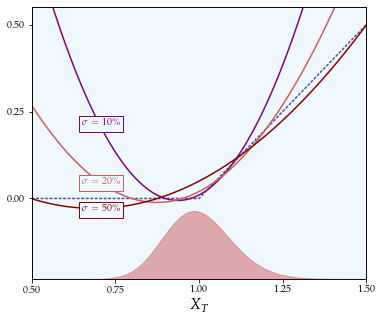

In [8]:
#============= Terminal payoff =============#
xs = np.linspace(0.5*x0,1.5*x0,201) # Space grid
G  = g(xs[__,:])                    # Terminal payoff 
    
col = 'midnightblue'
cols = ["purple","indianred","darkred",'mediumpurple','tomato','indianred',"plum","gold","steelblue"]
colCyc = cyc('color', cols)

save = 1
fig,ax = plt.subplots(1,1,figsize = (6,5))
ax.set_facecolor("aliceblue"); ax.set_prop_cycle(colCyc)#ax.set_prop_cycle(cyc('linestyle',['-','--','-.',':']))
ax.plot(xs,G,dashes = (2,1),lw = 1.5,color = col,label = "Call payoff",alpha = 0.75,zorder = -4) 
#ax.text(xs[160]-0.06,G[160]-0.1,r"$(X_T - X_0)^+$",color = col,alpha = 0.6,fontsize = 16)
# Replication using Bachelier embeddings / FTE
i = 0
for sig in [0.1,0.2,0.5]:
    # FTE coefficients
    lbda = statRep(sigBa = sig * x0); GHat = gHat(xs,lbda)
    ax.plot(xs,GHat,lw = 1.5,label = r"$\sigma = %2.f$"%(100*sig) + "\%")
    ax.text(xs[40]-0.05,GHat[40]-0.01,r"$\sigma = %2.f$"%(100*sig) + "\%",fontsize = 10,color = cols[i],
                    bbox = dict(edgecolor = cols[i],facecolor = 'aliceblue', pad=3))#,color = col
    i += 1
# Add Risk-neutral distribution of X_T (here log normal)
ax2 = ax.twinx()
rnDist = lognorm.pdf(xs, s = sigBS*np.sqrt(T),scale = np.exp(- sigBS**2 * T/2))
#ax.text(x0*0.92,-0.22,r"$\mathbb{Q} \circ X_T^{-1}$",color = col,fontsize = 15)
ax2.fill_between(xs,0.,rnDist,zorder = -2,alpha = 0.5,color = cols[1])
ax2.set_yticks([]); ax2.set_ylim(0.,4*np.max(rnDist))
ax.set_xlim(np.min(xs),np.max(xs)); ax.set_ylim(np.min(GHat)*1.1-0.2,np.max(G)*1.1)
ax.set_xticks(np.quantile(xs,np.linspace(0,1,5))); ax.set_yticks([0,0.25,0.5])
ax.set_xlabel(r"$X_T$",fontsize = 15)
#ax.legend(fontsize = 15,loc = "best",ncol = 1,frameon=False,labelcolor='linecolor')
if save: plt.savefig("Figures/callReplication, sigBS = %2.2f.pdf"%sigBS,dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()

BS price: 0.04


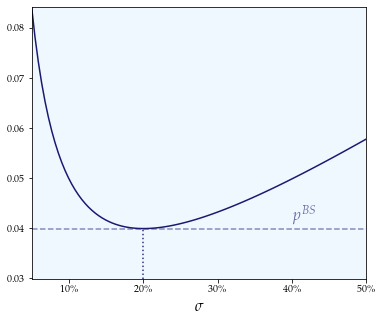

In [9]:
#============= Initial Price vs sig =============#

pBS,*_ = bsVanilla(x0,K,r,delta,sigBS,T)
print("BS price: %2.2f"%pBS)

sigs = np.linspace(0.05,0.5,101) # Space grid
    
col = 'midnightblue'
save = 1
fig,ax = plt.subplots(1,1,figsize = (6,5))
ax.set_facecolor("aliceblue"); #ax.set_prop_cycle(cyc('linestyle',['-','--','-.',':']))
ax.text(0.4,pBS*1.04,r"$p^{BS}$",color = col,alpha = 0.6,fontsize = 16)

ps = []
# Replication using Bachelier embeddings / FTE
for sig in sigs:
    # FTE coefficients
    lbda = statRep(sigBa = sig * x0)
    ps  += [pHat(lbda)]
ax.hlines(pBS,sigs[0],sigs[-1],ls = "--",color = col,alpha = 0.5)
yMin,yMax = pBS*0.75,np.max(ps)*1.1
ax.vlines(sigBS,yMin,pBS,ls = ":",color = col,alpha = 0.9)
ax.plot(sigs,ps,lw = 1.5,color = col,label = r"$\sigma = %2.f$"%(100*sig) + "\%")
ax.set_ylim(pBS*0.75,np.max(ps)*1.0); ax.set_xlim(np.min(sigs),np.max(sigs))
SIGS = [0.1,0.2,0.3,0.4,0.5]
ax.set_xticks(SIGS, labels = [r"$%2.f$"%(100*s) + "\%" for s in SIGS])
ax.set_xlabel(r"$\sigma$",fontsize = 15)
#ax.set_yticks([0])
#ax.legend(fontsize = 15,loc = "best",ncol = 1,frameon=False,labelcolor='linecolor')
if save: plt.savefig("Figures/callPrice.pdf",dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()

## bqplot Animation: Final Payoff (IMPROVE)

## bqplot Animation: Initial Price (IMPROVE)

### Asian Option

In [29]:
# Bachelier Embedding
def pAs(tau,a,K,sigBa): 
    """Price of fixed strike Asian call option in Bachelier model. 
       tau = time to maturity."""
    # Scaled volatility for Asian options (note that T is fixed throughout)
    sigAs = sigBa * tau / (np.sqrt(3) * T) 
    return p(tau,a,K,sigAs)

def statRepAsian(sigBa,T = T,h = 0.01, dT = 0.001):  
    """Static Replication using Bachelier embeddings. 
       Returns first FTE coefficients. """
    # Functional derivatives (FTE coefficients)
    lbda       = {}
    # Bachelier Price
    lbda["_"]  = pAs(T,x0,K,sigAs)                          
    # Bachelier Theta (forward difference)
    lbda["t"]  = (pAs(T-dT,x0,K,sigAs) - pAs(T,x0,K,sigBa))/dT 
    # Bachelier Delta (centered difference)
    lbda["x"]  = (pAs(T,T,x0 + h,K,sigBa) - pAs(T,x0 - h,K,sigBa))/(2*h) 
    # Bachelier Gamma (butterfly approximation)
    lbda["xx"] = (pAs(T,T,x0 + h,K,sigBa) - 2 * p(T,x0,K,sigBa) + p(T,x0 - h,K,sigBa))/h**2 
    return lbda

def gHat(xT,lbda,T = T):
    """Taylor approximation of g(X) given the coefficients (lbda^I)."""
    return lbda["_"] + lbda["t"] * T + lbda["x"] * (xT - x0) + lbda["xx"] * (xT - x0)**2/2

#def pHat(lbda):
#    """Initial price given the coefficients (lbda^I)."""
#    return lbda["_"] + lbda["t"] * T  + lbda["xx"] * (np.exp(sigBS**2 * T) - 1)/2

In [39]:
# Simulations
# Number of time steps
N = 100                 
ts  = np.linspace(0,T,N+1)  # Time grid (flat)
Ts  = ts[:,__]              # Time grid (column vector)
dt  = T/N                   # Time increments (here constant)

J    = 100000; rdm.seed(11)
sig  = 0.2
x0,K = 1,1
X    = x0 + sig * BM(Ts,J)
#G    = g(X)

g = lambda X: np.maximum(np.mean(X,axis = 0) - K,0.)

print("MC:    %2.6f"%MC(g(X)))

p_ = pAs(T,T,x0,K,sig)
print("Exact: %2.6f"%p_)

MC:    0.023020
Exact: 0.023033


<function __main__.MC(G, T=0.25, r=0.0)>